In [49]:
# !apt-get install -q libgeos-3.6.2
# !apt-get install -q libgeos-dev
# !pip install -q pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz
# !pip install -q https://github.com/matplotlib/basemap/packages/master.zip

<h2>Introduction</h2>
First let's explore a raw data a little bit, check the distributions, look for outliers and plan for future feature extraction. Start with importing neccessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from mpl_toolkits.basemap import Basemap
%matplotlib inline

Let's see how the training data and the test data look:

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/two-sigma-connect-rental-listing-inquiries.zip"
!unzip "/content/train.json.zip"
!unzip "/content/test.json.zip"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/two-sigma-connect-rental-listing-inquiries.zip
  inflating: Kaggle-renthop.torrent  
  inflating: images_sample.zip       
  inflating: sample_submission.csv.zip  
  inflating: test.json.zip           
  inflating: train.json.zip          
Archive:  /content/train.json.zip
  inflating: train.json              
Archive:  /content/test.json.zip
  inflating: test.json               


In [3]:
train = pd.read_json('/content/train.json')
test  = pd.read_json('/content/test.json')
print(f'Training set is of size:{train.shape}')
print(f'Test set is of size:{test.shape}')
train.head(1)
# test.head(1)

Training set is of size:(49352, 15)
Test set is of size:(74659, 14)


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium


In [4]:
print('Features in the dataset')
print('\n'.join(train.columns))

Features in the dataset
bathrooms
bedrooms
building_id
created
description
display_address
features
latitude
listing_id
longitude
manager_id
photos
price
street_address
interest_level


We will use a binary normalized histogram in further investigations, so let's define the method once to reuse it later:

In [5]:
def PlotNormHist(data, axes, binaryFeat):
    param = [False, True]
    for i,cur_ax in enumerate(axes):
        cur_data = data[data[binaryFeat]==param[i]]
        int_level = cur_data['interest_level'].value_counts()
        int_level = int_level/sum(int_level)
        sns.barplot(int_level.index, int_level.values, alpha=0.8,
                    order=['low','medium','high'], ax=cur_ax)
        cur_ax.set_xlabel(param[i], fontsize=15)
        cur_ax.set_ylim(bottom=0, top=1)
        cur_ax.grid()

<h2>Photos</h2>
At this stage we will try not to use the images at all, but it can be usefull to check if the total number of images per specific listing can help us in prediction. Let's create a new numerical column nPhotos and threshold the maximal number of photos to 10 to avoid strange outliers:

In [6]:
train['nPhotos'] = train['photos'].apply(lambda x: min(10, len(x)))

Now let's check the distribution over the "interest level", using the "violin" plot:

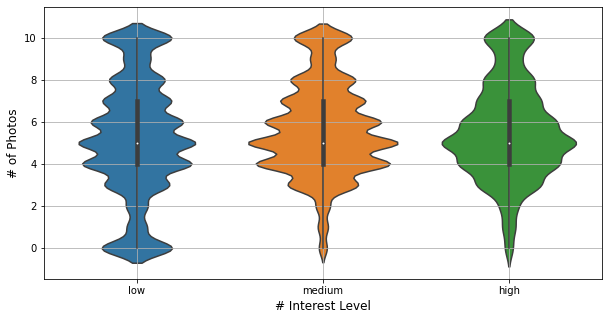

In [7]:
plt.figure(figsize=(10,5))
sns.violinplot(x='interest_level', y='nPhotos', data=train, order=['low','medium','high'])
plt.xlabel('# Interest Level', fontsize=12)
plt.ylabel('# of Photos', fontsize=12)
plt.grid()
plt.show()

We can see that a lack of photos significantly decreases the chances of the listing to be popular as we would expect.

<h2>Description</h2>
For now, we won't use the provided 'description' field. We can assume that written keywords in this field can play significant role in the prediction, so we want at least create a new column that will have a binary indication for every listing - True if the listing had some sort of description or False otherwise. Let's check the distribution over the "interest level" using the simple countplot:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


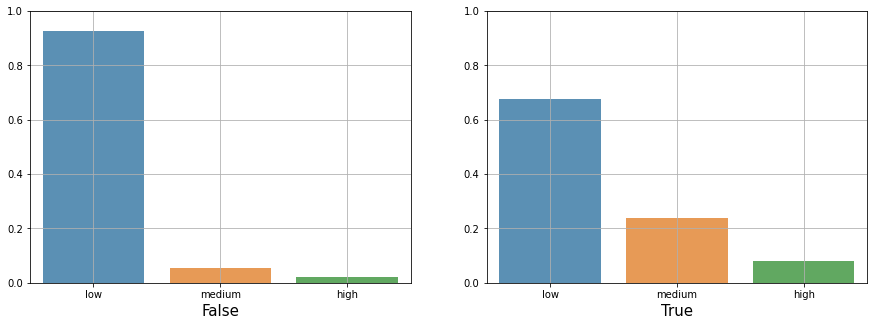

In [8]:
train['hasDesc'] = train['description'].apply(lambda x: len(x.strip())!=0)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
PlotNormHist(train, axes, 'hasDesc')

It is obvious that a lack of description lowers the chances of the listing to become popular.

<h2>Geographical Distribution</h2>
We can assume that geographical location of the listing will have a significant influence on the interest levels for this listing. Specifically we can think of a distribution of neighborhoods where some of them would be "prestigiuos" and other less. Let's try and plot the listings on map projection:

In [9]:
long_llim = np.percentile(train.longitude.values, 1)
long_ulimit = np.percentile(train.longitude.values, 99)
lat_llim = np.percentile(train.latitude.values, 1)
lat_ulimit = np.percentile(train.latitude.values, 99)
train = train[(train['longitude']>long_llim) & (train['longitude']<long_ulimit) & 
              (train['latitude']>lat_llim) & (train['latitude']<lat_ulimit)]
lats = list(train['latitude'])
lons = list(train['longitude'])

In [47]:
# fig = plt.figure(figsize=(15, 15))
# m = Basemap(projection='merc',llcrnrlat=min(lats),urcrnrlat=max(lats),\
#             llcrnrlon=min(lons),urcrnrlon=max(lons), resolution='h')
# x, y = m(lons,lats)
# sns.scatterplot(x, y, hue=train['interest_level'], style=train['interest_level'])

We can see that the density of the classes indeed differs, 
depending on the geographical location. There is no "hard" separator, but the usefullnes of the {lat, long} feature is obviuos. It may be nice to try and run a KNN classification and maybe create an additional feature that measures the distance of the listing from the center.

<h2>Price:</h2>
Let's see the distribution of the prices:


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


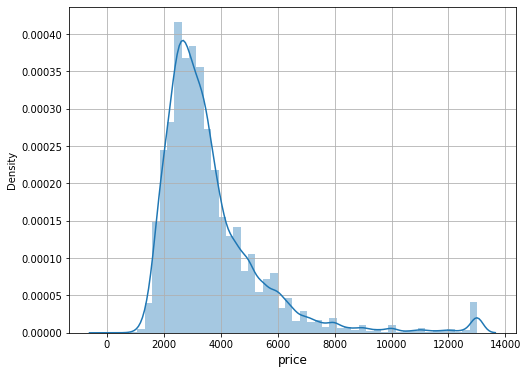

In [10]:
ulimit = np.percentile(train.price.values, 99)
train['price'][train['price']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(train.price.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.grid()
plt.show()

How does the price varies over the interest categories:

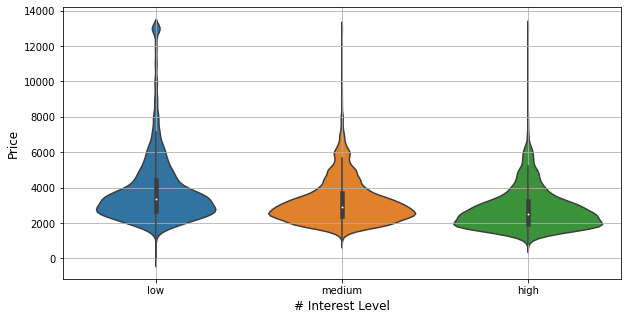

In [11]:
plt.figure(figsize=(10,5))
sns.violinplot(x='interest_level', y='price', data=train, order=['low','medium','high'])
plt.xlabel('# Interest Level', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid()
plt.show()

<h2>Features:</h2>
Let's check now the column of the categorical feature entries:
We will count the occurencies of every feature:

In [12]:
feat_dict = {}
for ind, row in train.iterrows():
    for f in row['features']:
        f = f.lower().replace('-', '')
        if f in feat_dict:
            feat_dict[f] += 1
        else:
            feat_dict[f] = 1 

Let's see the most common features:

In [176]:
new_feat_dict = {}
for k,v in feat_dict.items():
    if v>50: new_feat_dict[k] = v  
for key in new_feat_dict.keys():
  print(key)

dining room
prewar
laundry in building
dishwasher
hardwood floors
dogs allowed
cats allowed
doorman
elevator
no fee
laundry in unit
fitness center
loft
fireplace
roof deck
high speed internet
swimming pool
wheelchair access
reduced fee
common outdoor space
parking space
concierge
balcony
private outdoor space
publicoutdoor
garage
garden/patio
new construction
furnished
exclusive
terrace
outdoor space
livein superintendent
onsite laundry
lowrise
simplex
hardwood
wifi access
livein super
duplex
common roof deck
newly renovated
washer/dryer
pets on approval
pool
storage
no pets
laundry
multilevel
high ceilings
high ceiling
laundry room
subway
renovated
marble bath
granite kitchen
light
actual apt. photos
stainless steel appliances
central a/c
patio
roofdeck
residents garden
onsite garage
valet
washer in unit
dryer in unit
exposed brick
residents lounge
childrens playroom
garden
view
live in super
eat in kitchen
fulltime doorman
gym/fitness
walk in closet(s)
parking
green building
short te

Some common features can have different variations, for example {'parking', 'onsite garage','garage'} are basically the same and can be very significant (deriving from our daily experience trying to find parking).
Let's check for example someof the features for significance on interest level:

In [138]:
def CreateCategFeat(data, features_list):
    f_dict = {'hasParking':['parking','onsite garage', 'garage'], 'hasGym':['gym', 'fitness', 'health club'],
              'hasPool':['swimming pool', 'pool'], 'noFee':['no fee', "no broker's fees"],
              'hasElevator':['elevator'], 'hasGarden':['garden', 'patio', 'outdoor space'],
              'isFurnished': ['furnished', 'fully  equipped'], 
              'reducedFee':['reduced fee', 'low fee'],
              'hasAC':['air conditioning', 'central a/c', 'a/c', 'central air', 'central ac'],
              'hasRoof':['roof', 'sundeck', 'private deck', 'deck'],
              'petFriendly':['pets allowed', 'pet friendly', 'dogs allowed', 'cats allowed'],
              'shareable':['shares ok'], 'freeMonth':['month free'],
              'utilIncluded':['utilities included'],
              'laundryIncluded': ['laundry in building', 'laundry in unit', 'onsite laundry', 'washer/dryer' ,'washer in unit', 'dryer in unit'],
              'internetIncluded': ['high speed internet', 'wifi access']}
    for feature in features_list:
        data[feature] = 0
        for ind, row in data.iterrows():
            for f in row['features']:
                f = f.lower().replace('-', '')
                if any(e in f for e in f_dict[feature]):
                    data.at[ind, feature]= 1     
cat_features = ['hasParking', 'hasGym', 'hasPool', 'noFee', 'hasElevator',
                'hasGarden', 'isFurnished', 'reducedFee', 'hasAC', 'hasRoof',
                'petFriendly', 'shareable', 'freeMonth', 'utilIncluded', 'laundryIncluded', 'internetIncluded']
CreateCategFeat(train, cat_features)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

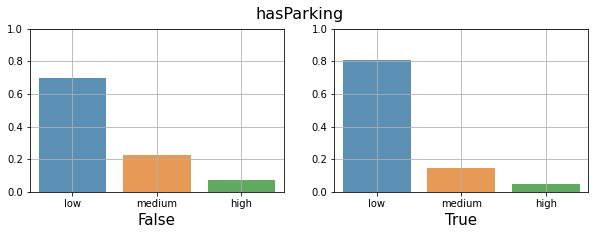

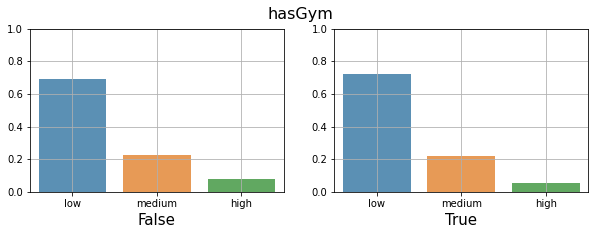

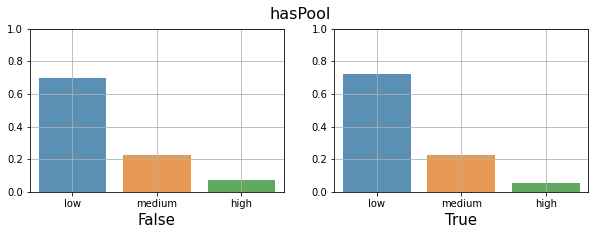

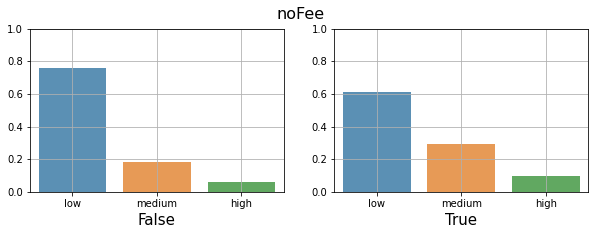

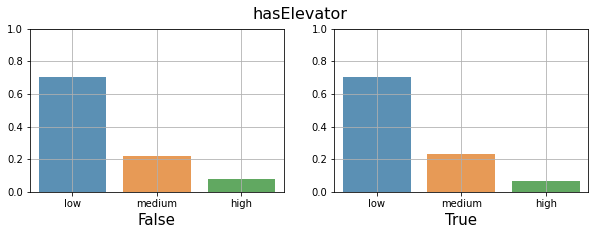

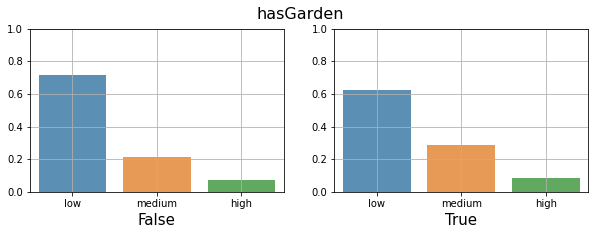

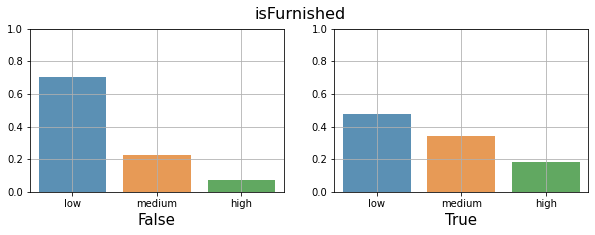

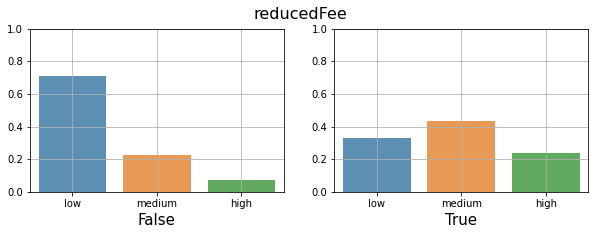

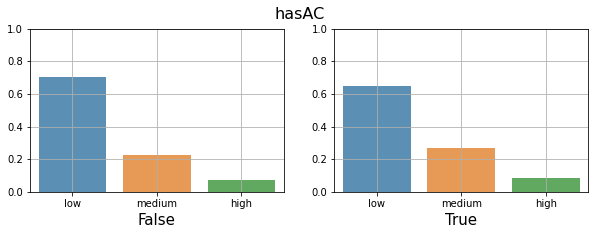

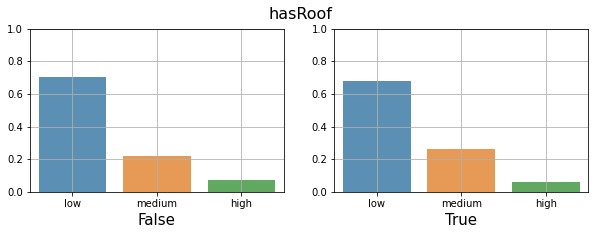

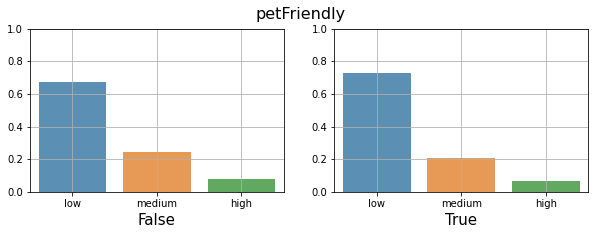

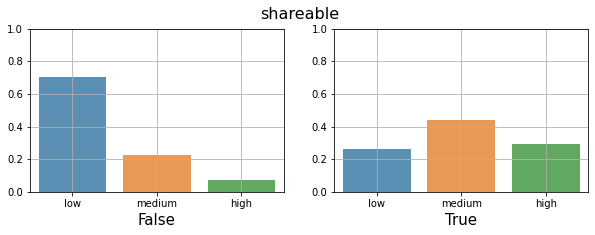

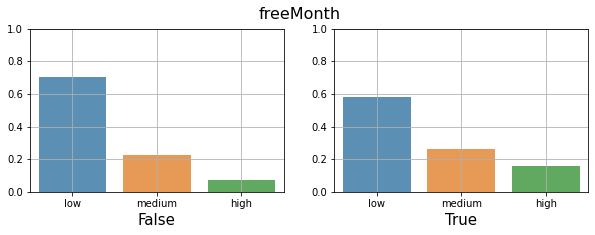

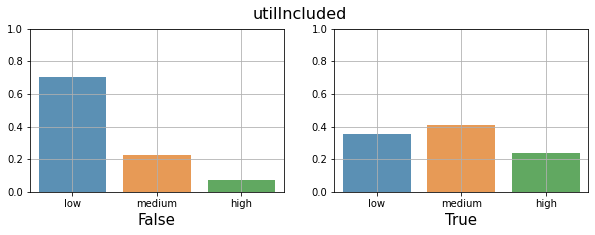

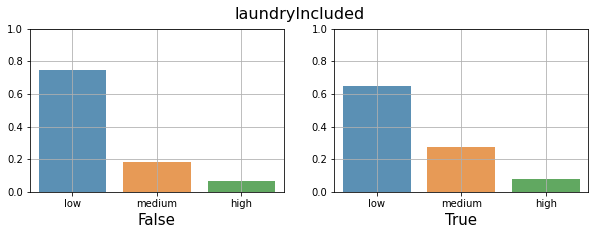

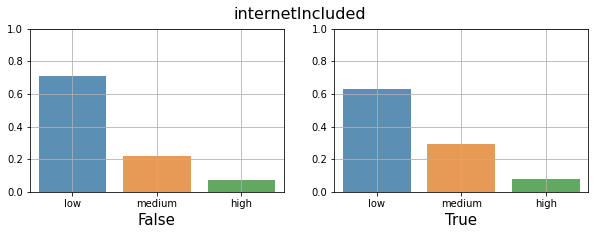

In [139]:
for cur_feature in cat_features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
    PlotNormHist(train, axes, cur_feature)
    fig.suptitle(cur_feature, fontsize=16)

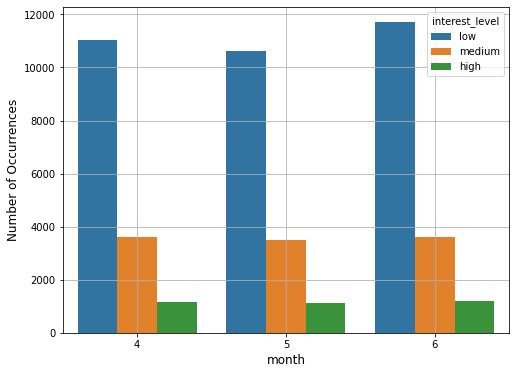

In [140]:
import datetime
train['created'] = pd.to_datetime(train['created'])
train['month']   = train['created'].dt.month
plt.figure(figsize=(8,6))
sns.countplot(x='month', hue='interest_level', data=train, hue_order=['low','medium','high'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('month', fontsize=12)
plt.grid()

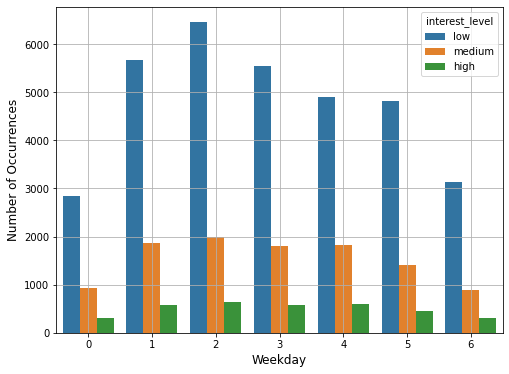

In [17]:
train['weekday'] = train['created'].apply(lambda x: x.weekday())
plt.figure(figsize=(8,6))
sns.countplot(x='weekday', hue='interest_level', data=train, hue_order=['low','medium','high'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Weekday', fontsize=12)
plt.grid()

<h2>Summary:</h2>
People are interested in apartment listings that have **description** and **photos**. Apartments with extreme outlied **prices** have less interest levels. 
Geographical location has significant value in terms of **latitude**, **longitude**.
People look for *furnished* , *air-conditioned* apartments that don't have an additional *fee* , have a *reduced fee* or have other $ perks as *free month* or *utilities included*.
Other features, exspecially *parking, gym, elevator* or *garden* can be important, but may be masked by the influence of the price.
In addition it looks like *shareable apartments* are popular, since more young population looks for roommates apartments.


In [19]:
"""From the above visualizations we can see that there are a lot of features that are affecting interest level for the rental properties"""
"""In this notebook, we will create some additional features from the existing features which might also be affecting the results"""
"""Note these features are based on common things I as a user look into and there is no research on there significance etc"""
"""Here is a list of features that I would think might also affect the interest"""
"""
Cost_per_room = total_rooms/total_cost
Cost_per_bedroom = total_bedroom/total_cost



'\nCost_per_room = total_rooms/total_cost\nCost_per_bedroom = total_bedroom/total_cost\nhas_email = if the property has an email\nhas_phonenumber = if the property has a number'

In [20]:
train['rooms'] = train[['bedrooms','bathrooms']].apply(lambda x: x[0]+x[1], axis=1)
train['price_per_room'] = train[['price','rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
train['price_per_bedroom'] = train[['price','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)


In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [141]:
def PrepareFeatures(path):
    source = path
    data = pd.read_json(source)
    # Some noise in price feature we saw in Part 1:
    ulimit = np.percentile(data.price.values, 99)
    data['price'][data['price']>ulimit] = ulimit
    # Get Different features as in Part 1:
    data['hasDesc'] = data['description'].apply(lambda x: 1 if len(x.strip())!=0 else 0)
    data["nFeatures"] = data["features"].apply(len)
    data["nDescWords"] = data["description"].apply(lambda x: len(x.split(" ")))
    data['nPhotos'] = data['photos'].apply(lambda x: min(10, len(x)))
    data['created'] = pd.to_datetime(data['created'])
    data['month'] = data['created'].dt.month
    data['weekday'] = data['created'].apply(lambda x: x.weekday())
    data['rooms'] = data[['bedrooms','bathrooms']].apply(lambda x: x[0]+x[1], axis=1)
    data['price_per_room'] = data[['price','rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
    data['price_per_bedroom'] = data[['price','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
    return data

In [171]:
data = PrepareFeatures('/content/train.json')
cat_features = ['hasParking', 'hasGym', 'hasPool', 'noFee', 'hasElevator',
                'hasGarden', 'isFurnished', 'reducedFee', 'hasAC', 'hasRoof',
                'petFriendly', 'shareable', 'freeMonth', 'utilIncluded', 'laundryIncluded','internetIncluded']
CreateCategFeat(data, cat_features)
features = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
             "nPhotos", "hasDesc", 'nFeatures', 'nDescWords', "month", 'weekday',
            'price_per_room','price_per_bedroom']
features.extend(cat_features)
# from sklearn.feature_extraction.text import CountVectorizer
# count_vect = CountVectorizer(stop_words='english')
# nb_x = count_vect.fit_transform(data["description"])
# data['description_vector'] = nb_x
# nb_x = count_vect.fit_transform(data["description"])
X = data[features]
y = data['interest_level']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)
clf = RandomForestClassifier(n_estimators=1000, criterion='entropy')
clf.fit(X_train, y_train)

y_val_pred = clf.predict(X_val)
print(clf.score(X_val, y_val))
# log_loss(y_val, y_val_pred)


In [161]:
import pickle

In [162]:
data = {'model':clf}

In [163]:
with open('rf_saved_model.pkl','wb') as f:
  pickle.dump(data,f)

In [100]:
temp_train = X_train
print(X_train.columns)
print(temp_train.to_numpy()[0])

Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'nPhotos',
       'hasDesc', 'nFeatures', 'nDescWords', 'month', 'weekday',
       'price_per_room', 'price_per_bedroom', 'hasParking', 'hasGym',
       'hasPool', 'noFee', 'hasElevator', 'hasGarden', 'isFurnished',
       'reducedFee', 'hasAC', 'hasRoof', 'petFriendly', 'shareable',
       'freeMonth', 'utilIncluded'],
      dtype='object')
[1.0 0 40.769 -73.9541 1850 0 True 1 91 4 1 1850.0 0.0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [101]:
# print(y_val.head)
# np_y_val = y_val.to_numpy()
# count = 0 
# for i,rec in enumerate(y_val_pred):
#   print(np.where(rec == np.amax(rec))[0] == 1)
#   pred = ''
#   if (np.where(rec == np.amax(rec))[0]) == 0:
#     pred = "low"
#   elif np.where(rec == np.amax(rec)) == 1:
#     pred = "medium"
#   elif np.where(rec == np.amax(rec)) == 2:
#     pred = "high"
#   if (pred == np_y_val[i]):
#     count+=1
# print(count/len(y_val_pred))

0.0


In [102]:
print(y_val)

110219    high
58727      low
80949      low
38542      low
57422      low
          ... 
79285      low
18414     high
21145      low
108563     low
38130      low
Name: interest_level, Length: 2468, dtype: object


In [144]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, weights='distance')
neigh.fit(X_train, y_train)
y_pred_val = neigh.predict(X_val)
neigh.score(X_val, y_val, sample_weight=None)

0.6499848039712288

In [165]:
data = {'model':neigh}
with open('knn_saved_model.pkl','wb') as f:
  pickle.dump(data,f)

In [109]:
np_y_val = y_val.to_numpy()
count = 0 
for i,rec in enumerate(y_pred_val):
  # print(rec, np_y_val[i])
  if (rec == np_y_val[i]):
    count+=1
print(count)
print(len(y_pred_val))
print(count/len(y_pred_val))

6349
9871
0.6431972444534495


In [172]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english')
clf = MultinomialNB()
nb_x = count_vect.fit_transform(data["description"])

X_train, X_val, y_train, y_val = train_test_split(nb_x, y, test_size=0.20)
clf.fit(X_train, y_train)
y_pred_val_nb = clf.predict(X_val)
clf.score(X_val, y_val)


0.6463377570661534

In [173]:
data = {'model':clf}
with open('nb_saved_model.pkl','wb') as f:
  pickle.dump(data,f)

In [167]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.svm import SVC
clf = make_pipeline(MinMaxScaler(), SVC(gamma='scale'))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)
clf.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svc', SVC())])

In [168]:
data = {'model':clf}
with open('svc_saved_model.pkl','wb') as f:
  pickle.dump(data,f)

In [159]:
clf.score(X_val, y_val)

0.6971938000202613

Sources⁉

https://www.kaggle.com/timsonrisa/two-rental-p-2-random-forest
https://www.kaggle.com/timsonrisa/two-rental-p-1-data-exploration/notebook
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
